In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/DL\ Proj/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj


### Velocity

In [2]:
!python velocity_test.py

test loaded
calculating test velocity
100% 2010/2010 [31:49<00:00,  1.05it/s]
/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj/velocity_test.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_velocity = np.array(test_velocity)
test_velocity50.npy


In [8]:
!python velocity.py

train loaded
calculating train velocity
100% 2550/2550 [41:06<00:00,  1.03it/s]
/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj/velocity.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_velocity = np.array(train_velocity)
train_velocity_36.npy


In [ ]:
# !python velocity_test.py

/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/*
/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/flows/*
test loaded
calculating test velocity
100% 2010/2010 [14:24<00:00,  2.32it/s]
/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj/velocity_test.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_velocity = np.array(test_velocity)


In [ ]:
# !python velocity.py

/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train/*
/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train/flows/*
train loaded
calculating train velocity
 99% 2535/2550 [21:13<00:07,  2.03it/s]

In [ ]:
%ls

'=2.0.1'                       Test_bounding_boxes.npy
 Accurate_Interpretable_VAD/   test.py
 coco_labels.txt               test_ucsd_velocity.npy
 flow_extraction_ped2.py       test_VAD.ipynb
 FlowNet2_checkpoint.pth.tar   Train_bounding_boxes.npy
 flownet2_pytorch/             train_ucsd_velocity.npy
 Flows_Imgs.zip                UCSD_Anomaly_Dataset.v1p2/
 Flows.ipynb                   VAD_repo.ipynb
 Flows_test.zip                Velocities.ipynb
 Flows.zip                     velocity.py
 imagenet_classes.txt          velocity_test.py
 Object_Detection_andrew       video_dataset.py
 object_detection.ipynb        yolov5/
 __pycache__/                  yolov5s.pt


In [ ]:
import numpy as np
from video_dataset import VideoDatasetWithFlows
import os
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from scipy.ndimage import gaussian_filter1d
from sklearn.mixture import GaussianMixture
import sys
from sklearn.mixture import GaussianMixture

def gaussian_video(video, lengths, sigma=3):
    scores = np.zeros_like(video)
    prev = 0
    for cur in lengths:
        scores[prev: cur] = gaussian_filter1d(video[prev: cur], sigma)
        prev = cur
    return scores

def macro_auc(video, test_labels, lengths):
    prev = 0
    auc = 0
    for i, cur in enumerate(lengths):
        cur_auc = roc_auc_score(np.concatenate(([0], test_labels[prev: cur], [1])),
                             np.concatenate(([0], video[prev: cur], [sys.float_info.max])))
        auc += cur_auc
        prev = cur
    return auc / len(lengths)


def evaluate(root):

    train_velocity = np.load(root + '/train_ucsd_velocity.npy', allow_pickle=True)
    train_velocity = np.concatenate(train_velocity, 0)

    test_velocity = np.load(root + '/test_ucsd_velocity.npy', allow_pickle=True)
    test_clip_lengths = np.load(root + '/UCSD_Anomaly_Dataset.v1p2/UCSDped2/test_clip_lengths.npy', allow_pickle= True)

    test_dataset = VideoDatasetWithFlows(dataset_name='ped2', root=root+ "/UCSD_Anomaly_Dataset.v1p2/UCSDped2/",
                                         train=False, sequence_length=0, all_bboxes=None, normalize=False, mode='last')
    velocity_density_estimator = GaussianMixture(n_components=2, random_state=0).fit(train_velocity)
    
    train_velocity_scores = -velocity_density_estimator.score_samples(train_velocity)
    print(train_velocity_scores.shape)

    min_velocity = np.min(train_velocity_scores)
    max_velocity = np.percentile(train_velocity_scores, 99.9)

    test_velocity_scores = []
    
    for i in tqdm(range(len(test_dataset)), total=len(test_dataset)):
        cur_velocity = test_velocity[i]

        max_score_velocity = np.max(-velocity_density_estimator.score_samples(cur_velocity))
        test_velocity_scores.append(max_score_velocity)

    test_velocity_scores = np.array(test_velocity_scores)
    print(test_velocity_scores.shape)

    test_velocity_scores = (test_velocity_scores - min_velocity) / (max_velocity - min_velocity)

    final_scores = gaussian_video(test_velocity_scores, test_clip_lengths, sigma=3)
    print(final_scores.shape)

    print('Micro AUC: ', roc_auc_score(test_dataset.all_gt, final_scores) * 100)
    print('Macro AUC: ', macro_auc(final_scores, test_dataset.all_gt, test_clip_lengths) * 100)

evaluate(os.getcwd())

/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/*
/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/flows/*
(30658,)


100%|██████████| 2010/2010 [00:00<00:00, 3443.82it/s]


(2010,)
(2010,)
Micro AUC:  96.36307863541276
Macro AUC:  98.38506647870182


In [ ]:
import numpy as np
from video_dataset import VideoDatasetWithFlows
import os
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from scipy.ndimage import gaussian_filter1d
from sklearn.mixture import GaussianMixture
import sys
from sklearn.mixture import GaussianMixture

def gaussian_video(video, lengths, sigma=3):
    scores = np.zeros_like(video)
    prev = 0
    for cur in lengths:
        scores[prev: cur] = gaussian_filter1d(video[prev: cur], sigma)
        prev = cur
    return scores

def macro_auc(video, test_labels, lengths):
    prev = 0
    auc = 0
    for i, cur in enumerate(lengths):
        cur_auc = roc_auc_score(np.concatenate(([0], test_labels[prev: cur], [1])),
                             np.concatenate(([0], video[prev: cur], [sys.float_info.max])))
        auc += cur_auc
        prev = cur
    return auc / len(lengths)


def evaluate(root):

    train_velocity = np.load(root + '/train_ucsd_velocity.npy', allow_pickle=True)
    train_velocity = np.concatenate(train_velocity, 0)

    test_velocity = np.load(root + '/test_ucsd_velocity.npy', allow_pickle=True)
    test_clip_lengths = np.load(root + '/UCSD_Anomaly_Dataset.v1p2/UCSDped2/test_clip_lengths.npy', allow_pickle= True)

    test_dataset = VideoDatasetWithFlows(dataset_name='ped2', root=root+ "/UCSD_Anomaly_Dataset.v1p2/UCSDped2/",
                                         train=False, sequence_length=0, all_bboxes=None, normalize=False, mode='last')
    velocity_density_estimator = GaussianMixture(n_components=8, random_state=0).fit(train_velocity)
    
    train_velocity_scores = -velocity_density_estimator.score_samples(train_velocity)

    min_velocity = np.min(train_velocity_scores)
    max_velocity = np.percentile(train_velocity_scores, 99.9)
    # max_velocity = np.max(train_velocity_scores)
    print(min_velocity, max_velocity)

    test_velocity_scores = []
    
    for i in tqdm(range(len(test_dataset)), total=len(test_dataset)):
        cur_velocity = test_velocity[i]

        max_score_velocity = np.max(-velocity_density_estimator.score_samples(cur_velocity))
        test_velocity_scores.append(max_score_velocity)

    test_velocity_scores = np.array(test_velocity_scores)

    test_velocity_scores = (test_velocity_scores - min_velocity) / (max_velocity - min_velocity)

    final_scores = gaussian_video(test_velocity_scores, test_clip_lengths, sigma=3)

    print('Micro AUC: ', roc_auc_score(test_dataset.all_gt, final_scores) * 100)
    print('Macro AUC: ', macro_auc(final_scores, test_dataset.all_gt, test_clip_lengths) * 100)

evaluate(os.getcwd())

/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/*
/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/flows/*
-0.2611285677317989 5.563633552129516


100%|██████████| 2010/2010 [00:00<00:00, 2306.01it/s]

Micro AUC:  97.6963538593574
Macro AUC:  98.16166307877616


In [ ]:
import numpy as np
from video_dataset import VideoDatasetWithFlows
import os
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from scipy.ndimage import gaussian_filter1d
from sklearn.mixture import GaussianMixture
import sys
from sklearn.mixture import GaussianMixture

def gaussian_video(video, lengths, sigma=3):
    scores = np.zeros_like(video)
    prev = 0
    for cur in lengths:
        scores[prev: cur] = gaussian_filter1d(video[prev: cur], sigma)
        prev = cur
    return scores

def macro_auc(video, test_labels, lengths):
    prev = 0
    auc = 0
    for i, cur in enumerate(lengths):
        cur_auc = roc_auc_score(np.concatenate(([0], test_labels[prev: cur], [1])),
                             np.concatenate(([0], video[prev: cur], [sys.float_info.max])))
        auc += cur_auc
        prev = cur
    return auc / len(lengths)


def evaluate(root):

    train_velocity = np.load(root + '/train_ucsd_velocity.npy', allow_pickle=True)
    train_velocity = np.concatenate(train_velocity, 0)

    test_velocity = np.load(root + '/test_ucsd_velocity.npy', allow_pickle=True)
    test_clip_lengths = np.load(root + '/UCSD_Anomaly_Dataset.v1p2/UCSDped2/test_clip_lengths.npy', allow_pickle= True)

    test_dataset = VideoDatasetWithFlows(dataset_name='ped2', root=root+ "/UCSD_Anomaly_Dataset.v1p2/UCSDped2/",
                                         train=False, sequence_length=0, all_bboxes=None, normalize=False, mode='last')
    velocity_density_estimator = GaussianMixture(n_components=2, random_state=0).fit(train_velocity)
    
    train_velocity_scores = -velocity_density_estimator.score_samples(train_velocity)

    min_velocity = np.min(train_velocity_scores)
    max_velocity = np.percentile(train_velocity_scores, 99.9)
    # max_velocity = np.max(train_velocity_scores)
    print(min_velocity, max_velocity)

    test_velocity_scores = []
    
    for i in tqdm(range(len(test_dataset)), total=len(test_dataset)):
        cur_velocity = test_velocity[i]

        max_score_velocity = np.max(-velocity_density_estimator.score_samples(cur_velocity))
        test_velocity_scores.append(max_score_velocity)

    test_velocity_scores = np.array(test_velocity_scores)

    test_velocity_scores = (test_velocity_scores - min_velocity) / (max_velocity - min_velocity)

    final_scores = gaussian_video(test_velocity_scores, test_clip_lengths, sigma=2)

    print('Micro AUC: ', roc_auc_score(test_dataset.all_gt, final_scores) * 100)
    print('Macro AUC: ', macro_auc(final_scores, test_dataset.all_gt, test_clip_lengths) * 100)

evaluate(os.getcwd())

/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/*
/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/flows/*
-0.2382250325772528 4.703441899023086


100%|██████████| 2010/2010 [00:00<00:00, 4557.95it/s]

Micro AUC:  95.98709971571098
Macro AUC:  98.18551190954302


### Inference

In [ ]:
%pwd

'/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj'

Inside Visual Flow


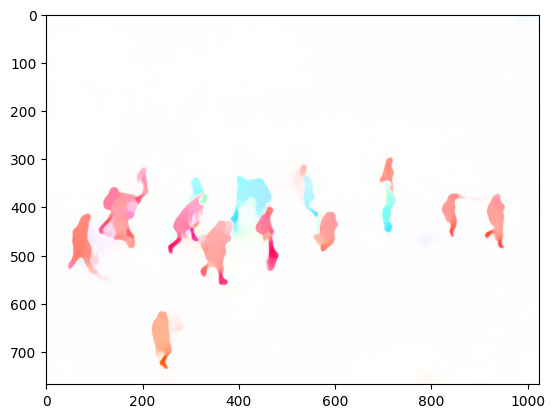

In [ ]:
from flownet2_pytorch.utils import flow_utils

org_file = '/content/drive/MyDrive/DL Proj/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train/flows_imgs/Train001/048.tif.flo'

flow_utils.visulize_flow_file(org_file) #, '/content/drive/MyDrive/DL Proj/')

In [ ]:
from flownet2_pytorch.utils import flow_utils

org_file = '/content/drive/MyDrive/DL Proj/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train/flows/Train001/049.tif.npy'

flow_utils.visulize_flow_file(org_file) #, '/content/drive/MyDrive/DL Proj/')

Inside Visual Flow
Magic number incorrect. Invalid .flo file


TypeError: ignored

In [ ]:
# !python test.py

  0% 0/2550 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj/test.py", line 31, in <module>
    for idx, (batch, _) in tqdm(enumerate(dataloader), total=len(dataset)):
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1178, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 634, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 678, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibl